In [98]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform, shift
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter


In [129]:
def translate_to_origin(points):
    """
    Translates a set of points so that their centroid is at the origin.
    
    Parameters:
    points (numpy.ndarray): An array of shape (3, 3) representing the vertices of the triangle.
    
    Returns:
    numpy.ndarray: Translated points with the centroid at the origin.
    numpy.ndarray: The original centroid of the points.
    """
    centroid = np.mean(points, axis=0)
    translated_points = points - centroid
    return translated_points, centroid

def scale_to_match(points1, points2):
    """
    Scales points1 to match the scale of points2.
    
    Parameters:
    points1 (numpy.ndarray): An array of shape (3, 3) representing the vertices of the first triangle.
    points2 (numpy.ndarray): An array of shape (3, 3) representing the vertices of the second triangle.
    
    Returns:
    numpy.ndarray: Scaled points1.
    float: The scaling factor.
    """
    size1 = np.linalg.norm(points1[1] - points1[0])
    size2 = np.linalg.norm(points2[1] - points2[0])
    scale_factor = size2 / size1
    scaled_points1 = points1 * scale_factor
    return scaled_points1, scale_factor

def kabsch_algorithm(P, Q):
    """
    Finds the optimal rotation matrix using the Kabsch algorithm.
    
    Parameters:
    P (numpy.ndarray): An array of shape (3, 3) representing the vertices of the first triangle.
    Q (numpy.ndarray): An array of shape (3, 3) representing the vertices of the second triangle.
    
    Returns:
    numpy.ndarray: The rotation matrix.
    """
    C = np.dot(P.T, Q)
    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        V[:, -1] = -V[:, -1]

    rotation_matrix = np.dot(V, W)
    return rotation_matrix

def align_triangles(triangle1, triangle2):
    """
    Aligns triangle1 to triangle2.
    
    Parameters:
    triangle1 (numpy.ndarray): An array of shape (3, 3) representing the vertices of the first triangle.
    triangle2 (numpy.ndarray): An array of shape (3, 3) representing the vertices of the second triangle.
    
    Returns:
    numpy.ndarray: Transformed vertices of triangle1.
    numpy.ndarray: The rotation matrix.
    numpy.ndarray: The translation vector.
    float: The scaling factor.
    """
    # Step 1: Translate both triangles to origin
    translated_triangle1, centroid1 = translate_to_origin(triangle1)
    translated_triangle2, centroid2 = translate_to_origin(triangle2)
    
    # Step 2: Scale triangle1 to match the size of triangle2
    scaled_triangle1, scale_factor = scale_to_match(translated_triangle1, translated_triangle2)
    
    # Step 3: Find the optimal rotation using the Kabsch algorithm
    rotation_matrix = kabsch_algorithm(scaled_triangle1, translated_triangle2)
    
    # Apply the rotation to scaled_triangle1
    rotated_triangle1 = np.dot(scaled_triangle1, rotation_matrix)
    
    # Translate rotated_triangle1 back to the position of triangle2
    transformed_triangle1 = rotated_triangle1 + centroid2
    
    return transformed_triangle1, rotation_matrix, centroid2 - scale_factor * np.dot(centroid1, rotation_matrix), scale_factor

def rotation_matrix_to_euler_angles(R):
    """
    Extracts the Euler angles from a rotation matrix.
    
    Parameters:
    R (numpy.ndarray): A 3x3 rotation matrix.
    
    Returns:
    tuple: The Euler angles (theta_x, theta_y, theta_z) in radians.
    """
    assert R.shape == (3, 3), "Input rotation matrix must be 3x3"
    
    if R[2, 0] != 1 and R[2, 0] != -1:
        theta_y = -np.arcsin(R[2, 0])
        cos_theta_y = np.cos(theta_y)
        theta_x = np.arctan2(R[2, 1] / cos_theta_y, R[2, 2] / cos_theta_y)
        theta_z = np.arctan2(R[1, 0] / cos_theta_y, R[0, 0] / cos_theta_y)
    else:
        # Gimbal lock case
        theta_z = 0
        if R[2, 0] == -1:
            theta_y = np.pi / 2
            theta_x = np.arctan2(R[0, 1], R[0, 2])
        else:
            theta_y = -np.pi / 2
            theta_x = np.arctan2(-R[0, 1], -R[0, 2])
    
    return theta_x, theta_y, theta_z

def rotation_matrix_from_angles(theta_x, theta_y, theta_z):
    """
    Creates a combined rotation matrix from rotations around the x, y, and z axes.
    
    Parameters:
    theta_x (float): Rotation angle around the x-axis in degees.
    theta_y (float): Rotation angle around the y-axis in degrees.
    theta_z (float): Rotation angle around the z-axis in degrees.
    
    Returns:
    numpy.ndarray: The combined rotation matrix.
    """
    theta_x = np.radians(theta_x)
    theta_y = np.radians(theta_y)
    theta_z = np.radians(theta_z)
    # Rotation matrix for the x-axis
    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(theta_x), -np.sin(theta_x)],
        [0, np.sin(theta_x), np.cos(theta_x)]
    ])
    
    # Rotation matrix for the y-axis
    R_y = np.array([
        [np.cos(theta_y), 0, np.sin(theta_y)],
        [0, 1, 0],
        [-np.sin(theta_y), 0, np.cos(theta_y)]
    ])
    
    # Rotation matrix for the z-axis
    R_z = np.array([
        [np.cos(theta_z), -np.sin(theta_z), 0],
        [np.sin(theta_z), np.cos(theta_z), 0],
        [0, 0, 1]
    ])
    
    # Combined rotation matrix
    R = np.dot(R_z, np.dot(R_y, R_x))
    
    return R

def apply_rotation_matrix(image_stack, rotation_matrix):
    """
    Applies a rotation matrix to a 3D image stack.
    
    Parameters:
    image_stack (numpy.ndarray): A 3D numpy array representing the image stack (depth, height, width).
    rotation_matrix (numpy.ndarray): A 3x3 rotation matrix.
    
    Returns:
    numpy.ndarray: The rotated image stack, same shape as the input.
    """
    # Compute the center of the image stack
    center = np.array(image_stack.shape) / 2
    
    # Construct the affine transformation matrix
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    transformation_matrix[:3, 3] = center - np.dot(rotation_matrix, center)
    
    # Apply the affine transformation
    rotated_image_stack = affine_transform(
        image_stack, 
        transformation_matrix[:3, :3], 
        offset=transformation_matrix[:3, 3],
        mode='nearest'
    )
    
    return rotated_image_stack

def visualize_image_stacks(original_stack, rotated_stack):
    """
    Visualizes the original and rotated image stacks.
    
    Parameters:
    original_stack (numpy.ndarray): The original 3D image stack.
    rotated_stack (numpy.ndarray): The rotated 3D image stack.
    """
    fig, axes = plt.subplots(2, original_stack.shape[0], figsize=(15, 5))
    
    for i in range(original_stack.shape[0]):
        axes[0, i].imshow(original_stack[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original Slice {i+1}')
        
        axes[1, i].imshow(rotated_stack[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Rotated Slice {i+1}')
    
    plt.tight_layout()
    plt.show()

def plot_triangles(triangle1, transformed_triangle1, triangle2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Original triangle1
    ax.scatter(triangle1[:, 0], triangle1[:, 1], triangle1[:, 2], color='r', label='Original Triangle 1')
    ax.plot(triangle1[:, 0], triangle1[:, 1], triangle1[:, 2], color='r')
    
    # Transformed triangle1
    ax.scatter(transformed_triangle1[:, 0], transformed_triangle1[:, 1], transformed_triangle1[:, 2], color='b', label='Transformed Triangle 1')
    ax.plot(transformed_triangle1[:, 0], transformed_triangle1[:, 1], transformed_triangle1[:, 2], color='b')
    
    # Triangle 2
    ax.scatter(triangle2[:, 0], triangle2[:, 1], triangle2[:, 2], color='g', label='Triangle 2')
    ax.plot(triangle2[:, 0], triangle2[:, 1], triangle2[:, 2], color='g')
    
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

def animate_plot_triangles(triangle1, transformed_triangle1, triangle2, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Setting up the plot elements that will be updated
    orig_scatter, = ax.plot(triangle1[:, 0], triangle1[:, 1], triangle1[:, 2], 'ro-', label='Original Triangle 1')
    trans_scatter, = ax.plot(transformed_triangle1[:, 0], transformed_triangle1[:, 1], transformed_triangle1[:, 2], 'bo-', label='Transformed Triangle 1')
    target_scatter, = ax.plot(triangle2[:, 0], triangle2[:, 1], triangle2[:, 2], 'go-', label='Triangle 2')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    
    # Animation function
    def update(num):
        ratio = num / 100
        trans_points = (1 - ratio) * triangle1 + ratio * transformed_triangle1
        
        trans_scatter.set_data(trans_points[:, 0], trans_points[:, 1])
        trans_scatter.set_3d_properties(trans_points[:, 2])
        
        # Rotate the plot view
        ax.view_init(elev=30, azim=num * 3.6)
        
        return trans_scatter,
    
    ani = FuncAnimation(fig, update, frames=101, interval=30, blit=False)
    
    # Save animation as GIF
    ani.save(filename, writer=PillowWriter(fps=20))
    plt.show()


 
def apply_transformation(image_stack, rotation_matrix, translation_vector, scale_factor):
    """
    Applies transformation parameters to a 3D image stack.
    
    Parameters:
    image_stack (numpy.ndarray): A 3D array of shape (depth, height, width) representing the image stack, 
                                  where depth is the number of images, height is the height, and width is the width.
    rotation_matrix (numpy.ndarray): The rotation matrix obtained from align_triangles.
    translation_vector (numpy.ndarray): The translation vector obtained from align_triangles.
    scale_factor (float): The scaling factor obtained from align_triangles.
    
    Returns:
    numpy.ndarray: Transformed 3D image stack.
    """
    new_shape = tuple(np.round(np.array(image_stack.shape)*scale_factor).astype(int))
    image_stack = resize(image_stack, new_shape, mode='constant', anti_aliasing=True)
    depth, height, width = image_stack.shape
    transformed_stack = np.empty_like(image_stack)
    
    # Apply transformation to each slice
    for d in range(depth):
        for h in range(height):
            for w in range(width):
                
                # Apply rotation
                rotated_pixel = np.dot(rotation_matrix, image_stack[d, h, w])
                print(rotated_pixel.shape)
                # Apply translation
                translated_pixel = rotated_pixel + translation_vector
                print(translated_pixel.shape)
                transformed_stack[d, h, w] = translated_pixel
    
    return transformed_stack

NameError: name 'transformed_stack' is not defined

In [121]:


ptsA = np.array([[5.        , 76.28330104, 65.61964529],
       [5.        , 70.74989779, 46.45035545],
       [1.        , 29.60293949, 34.05793506]])
ptsB = np.array([[ 61.        , 249.37681159, 593.44202899],
       [ 61.        ,  64.47101449, 495.13768116],
       [ 43.        ,  64.47101449,  36.38405797]])

transformed_triangle1, R, translation_vector, scale_factor = align_triangles(ptsB, ptsA)
theta_x, theta_y, theta_z = rotation_matrix_to_euler_angles(R)
print("Theta_x (degrees):", np.degrees(theta_x))
print("Theta_y (degrees):", np.degrees(theta_y))
print("Theta_z (degrees):", np.degrees(theta_z))

lami2ide = tiff.imread("lami2ide.tiff")
lami2ide = lami2ide[19:37]
lami2bm = tiff.imread("lami2bm.tiff")

# #downscale lami2bm based on scale_factor
# new_shape = tuple(np.round(np.array(lami2bm.shape)*scale_factor).astype(int))
# downscaled = resize(lami2bm, new_shape, mode='constant', anti_aliasing=True)

# print(downscaled.shape)
# print(lami2ide.shape)


Theta_x (degrees): 74.02791638523333
Theta_y (degrees): -7.614750914315949
Theta_z (degrees): -175.4495067449307


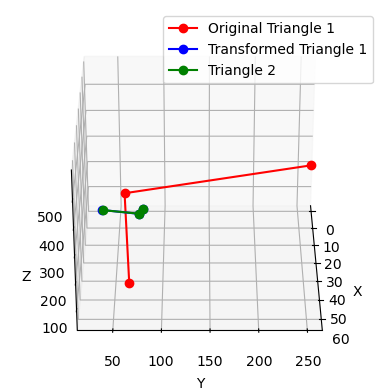

In [107]:
animate_plot_triangles(ptsB, transformed_triangle1, ptsA, 'triangle_alignment.gif' )

In [120]:
R = rotation_matrix_from_angles(100, -7.614750914315949, -175.4495067449307)
print(R.shape)

(3, 3)


In [130]:
# rotated_stack = apply_rotation_matrix(downscaled, R)

rotated_stack = apply_transformation(lami2bm, R, translation_vector, scale_factor)

#shift images to centroid
# translated_image_stack = shift(downscaled, shift=translation_vector, mode='nearest')
visualize_image_stacks(lami2ide, rotated_stack)



ValueError: setting an array element with a sequence.